### Loading environ

In [1]:

from aiida import orm, engine, load_profile
from aiida.common import NotExistent

# import aiida_dislocation
# import importlib
# importlib.reload(aiida_dislocation.workflows.usf)
from aiida_dislocation.workflows.usf import USFWorkChain
from aiida_dislocation.calculations.thermo_pw import Thermo_pwBaseCalculation

from ase.io import read
from ase.build import bulk
from aiida.engine import run, submit

import logging

import yaml
from itertools import islice

load_profile()

group_label = 'test/calcjobs/thermo_pw/'
test_thermo_pw_group, created = orm.Group.collection.get_or_create(label=group_label)
if created:
    print(f"Group '{group_label}' created.")
else:
    print(f"Group '{group_label}' already exists.")

epw_stable_group, created = orm.Group.collection.get_or_create(label='paper/workchains/epw/stable')


computer = 'mn5'
mn5_computer = orm.load_computer(computer)
mn5_computer.set_workdir('/gpfs/scratch/ehpc14/uclo653525/aiida_workdir/test/')

version = '7.3'
thermo_pw_label = f'thermo_pw-{version}'
thermo_pw_code = orm.load_code(f'{thermo_pw_label}@{computer}')

pseudo_family = orm.load_group('PseudoDojo/0.5/PBE/SR/standard/upf')


Group 'test/calcjobs/thermo_pw/' already exists.


In [2]:

def get_inputs_from_epw_workchain(wc):
    w90_bands = wc.base.links.get_outgoing(link_label_filter='w90_bands').first().node
    scf = w90_bands.base.links.get_outgoing(link_label_filter='scf').first().node


    thermo_pw_overrides_yaml = open('./thermo_pw.yaml')
    thermo_pw_overrides = yaml.safe_load(thermo_pw_overrides_yaml)

    inputs = {
        'structure':wc.inputs.structure,
        'kpoints': scf.inputs.kpoints,
        'pseudos': scf.inputs.pw.pseudos,
        'parameters': scf.inputs.pw.parameters.get_dict(),
        'code': thermo_pw_code,
        'metadata': thermo_pw_overrides.get('metadata', {}),
        'thermo_control': thermo_pw_overrides.get('thermo_control', {}),
    }
    
    return inputs

### Test Aluminium

In [18]:

ase_atom = read('./structures/cif/Al-225-A1.cif', format='cif')
structure = orm.StructureData(ase=ase_atom)

kpoints = orm.KpointsData()
kpoints.set_kpoints_mesh((12, 12, 12))
pseudos = pseudo_family.get_pseudos(structure=structure)


thermo_pw_overrides_yaml = open('./thermo_pw.yaml')
thermo_pw_overrides = yaml.safe_load(thermo_pw_overrides_yaml)


inputs = {
    'structure':structure,
    'kpoints': kpoints,
    'pseudos': pseudos,
    'code': thermo_pw_code,
    'metadata': thermo_pw_overrides.get('metadata', {}),
    'thermo_control': thermo_pw_overrides.get('thermo_control', {}),
    'parameters': thermo_pw_overrides.get('parameters', {}),
}

inputs

{'structure': <StructureData: uuid: af5b85de-88b1-4fec-9383-cb7c2332314d (unstored)>,
 'kpoints': <KpointsData: uuid: 40147379-3cd9-4233-bacd-e582a06e42db (unstored)>,
 'pseudos': {'Al': <UpfData: uuid: 6cd44de8-54b1-42c7-8e65-2b3e078cd7de (pk: 42779)>},
 'code': <InstalledCode: Remote code 'thermo_pw-7.3' on mn5 pk: 64974, uuid: 909887bb-617d-45b2-852c-4868dc75fa51>,
 'metadata': {'options': {'resources': {'num_machines': 1,
    'num_mpiprocs_per_machine': 56,
    'num_cores_per_machine': 56},
   'max_wallclock_seconds': 7200,
   'account': 'ehpc14',
   'queue_name': 'gp_debug',
   'qos': 'gp_debug',
   'append_text': 'rm out/*wfc*'}},
 'thermo_control': {'what': 'scf_elastic_constants',
  'find_ibrav': True,
  'frozen_ions': False},
 'parameters': {'CONTROL': {'calculation': 'scf',
   'tstress': True,
   'disk_io': 'nowf'},
  'SYSTEM': {'ecutwfc': 100.0,
   'ecutrho': 400.0,
   'smearing': 'cold',
   'degauss': 0.02,
   'nosym': False,
   'noinv': False,
   'occupations': 'smearing'}

In [6]:

logging.getLogger('aiida.transport.SshTransport') .setLevel(logging.ERROR)
logging.getLogger('aiida.scheduler.slurm').setLevel(logging.ERROR)

test_node = run.get_node(Thermo_pwBaseCalculation, **inputs)
test_thermo_pw_group.add_nodes(test_node.node)

### Test parser

In [2]:
import re
import numpy

from aiida_dislocation.parsers.thermo_pw import ThermoPwParser

calc = orm.load_node(142229)
aiida_out = calc.outputs.retrieved.get_object_content('aiida.out')
from aiida_quantumespresso.utils.mapping import get_logging_container

logs = get_logging_container()

parsed_data, logs = ThermoPwParser.parse_stdout(aiida_out, logs)

for key, value in parsed_data.items():
    print(key, value)

print(parsed_data['fitting'])

1 {'strain': [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, -0.0075]], 'total_energy': -4.6355042, 'smearing_contrib': -3.032e-05, 'internal_energy': -4.63547388, 'one_electron': 2.99116711, 'hartree': 0.0077032, 'xc': -2.18128082, 'ewald': -5.45306337, 'stress': [[-3.1123, 20.958, 21.0367], [1.0, 0.0, 0.0], [-2.9201, 18.3728, 20.4178], [1.0, 0.0, 0.0], [-2.3453, 14.9644, 19.7175], [1.0, 0.0, 0.0], [-1.3923, 11.7127, 19.2652], [1.0, 0.0, 0.0], [-0.0688, 8.722, 19.1146], [1.0, 0.0001, 0.0], [1.6143, 6.0318, 19.2784], [1.0, 1.0, 0.0], [3.5071, 3.8025, 19.7151], [1.0, 1.0, 0.0], [-2.8574, 19.2897, 19.3534], [1.0, 0.0, 0.0], [-2.4116, 16.1938, 18.4429], [1.0, 0.0, 0.0], [-1.5862, 12.9136, 17.8724], [1.0, 0.0, 0.0], [-0.3879, 9.8452, 17.6195], [1.0, 0.0, 0.0], [1.1736, 7.0585, 17.6877], [1.0, 1.0, 0.0], [3.0786, 4.5927, 17.2994], [1.0, 1.0, 0.0], [2.4222, 5.3583, 16.6931], [1.0, 1.0, 0.0], [0.6244, 7.9336, 16.4222], [1.0, 0.8656, 0.0], [-0.8198, 10.8119, 16.4907], [1.0, 0.0, 0.0], [-1.8972, 

### Test epw-stable

In [3]:
qb = orm.QueryBuilder()
qb.append(
    orm.Group,
    filters={'label': 'paper/workchains/epw/stable'},
    tag='epw_stable'
    ).append(
    orm.WorkChainNode,
    with_group='epw_stable',
    # filters={'extras.source_db': test_source_structure['source_db'], 'extras.source_id': test_source_structure['source_id']},
    tag='epw_wc',
    # project=["*", "extras.source_db", "extras.source_id"],
)


QueryBuilder(path=[{'entity_type': 'group.core', 'orm_base': 'group', 'tag': 'epw_stable', 'joining_keyword': None, 'joining_value': None, 'edge_tag': None, 'outerjoin': False}, {'entity_type': 'process.workflow.workchain.WorkChainNode.', 'orm_base': 'node', 'tag': 'epw_wc', 'joining_keyword': 'with_group', 'joining_value': 'epw_stable', 'edge_tag': 'epw_stable--epw_wc', 'outerjoin': False}], filters={'epw_stable': {'type_string': {'like': '%'}, 'label': 'paper/workchains/epw/stable'}, 'epw_wc': {'node_type': {'like': 'process.workflow.workchain.%'}}, 'epw_stable--epw_wc': {}}, project={'epw_stable': [], 'epw_wc': [], 'epw_stable--epw_wc': []}, project_map={}, order_by=[], limit=None, offset=None, distinct=False)

In [7]:
logging.getLogger('aiida.transport.SshTransport') .setLevel(logging.ERROR)
logging.getLogger('aiida.scheduler.slurm').setLevel(logging.ERROR)

epw_wc = qb.first()[0]
inputs = get_inputs_from_epw_workchain(epw_wc)
# result = run.get_node(Thermo_pwBaseCalculation, **inputs)
# test_node = result.node
# test_thermo_pw_group.add_nodes(test_node)

thermo_pw_workchain = engine.submit(Thermo_pwBaseCalculation, **inputs)
test_thermo_pw_group.add_nodes(thermo_pw_workchain)
extras = epw_wc.base.extras.all
thermo_pw_workchain.base.extras.set_many(extras=extras)



In [9]:
logging.getLogger('aiida.transport.SshTransport') .setLevel(logging.ERROR)
logging.getLogger('aiida.scheduler.slurm').setLevel(logging.ERROR)


for epw_wc in qb.all(flat=True)[:5]:
    
    print(
        epw_wc.base.extras.get('source_db'), 
        epw_wc.base.extras.get('source_id'),
        epw_wc.inputs.structure.get_formula()
    )
    
    inputs = get_inputs_from_epw_workchain(epw_wc)
    
    thermo_pw_workchain = submit(Thermo_pwBaseCalculation, **inputs)
    print(f"✅ Submitted: PK = {thermo_pw_workchain.pk}")
    test_thermo_pw_group.add_nodes(thermo_pw_workchain)
    
    extras = epw_wc.base.extras.all
    thermo_pw_workchain.base.extras.set_many(extras=extras)
    


mpds S534147 CTa
✅ Submitted: PK = 180330
mpds S1420799 MoN
✅ Submitted: PK = 180333
icsd 77392 CRu3Ta
✅ Submitted: PK = 180336
mpds S1210913 CY
✅ Submitted: PK = 180339
icsd 77216 CNbRu3
✅ Submitted: PK = 180342


In [11]:

qb = orm.QueryBuilder()
qb.append(
    orm.Group,
    filters={'label': group_label},
    tag='thermo_pw'
    ).append(
    orm.CalcJobNode,
    with_group='thermo_pw',
    filters={
        'attributes.process_state': 'finished', 
        'attributes.process_label': 'ThermoPwBaseCalculation',
        'attributes.exit_status': 0, 
        },
    # project=["*", "extras.source_db", "extras.source_id"],
)

qb.all()

[]

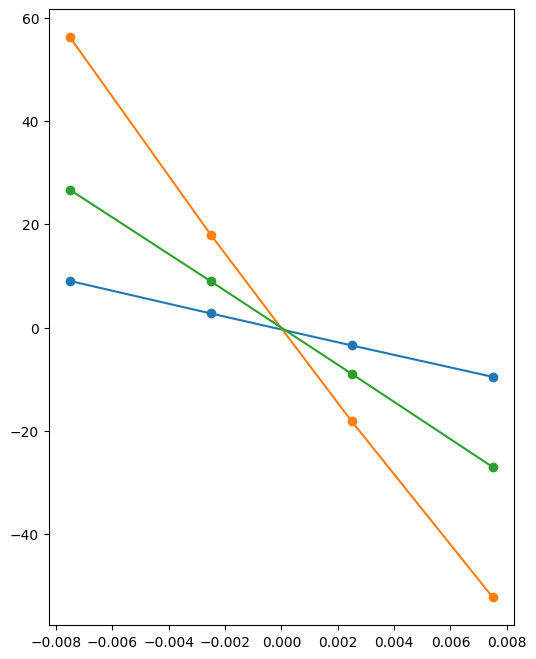

In [20]:
import matplotlib.pyplot as plt
import numpy

fitting = result.result.get('output_parameters').get('fitting')

fig, ax = plt.subplots(1, 1, figsize=(6, 8))

for strain, _info in fitting.items():
    for stress, info in _info.items():
        strains = numpy.array(info.get('strains'))
        stresses = numpy.array(info.get('stresses'))
        ax.scatter(strains, stresses)
        ax.plot(strains, stresses)